### Introduction

Now that the brief [overview of visual analyses](https://nbviewer.org/github/yl5787/hotel-booking-demand/blob/main/0-overview%20of%20visual%20analyses.ipynb) of the data set has been conducted, it is time to look into what the executives may be inquisitive about regarding the hotels' performance. From the viewpoint of the executives, several questions have arised and corresponding data-driven answers/findings will be presented one after another.

This Jupyter Notebook document handles the first in-depth question that the executives of the hospitality establishment may conceive: **what makes a guest visit again?** 

This analysis centers around a feature called '*is_repeated_guest*' which is a dichotomous variable of values 0 for "non-repeated guest" and 1 for "repeated guest." The rest of the features will be paired with '*is_repeated_guest*' and examined for possible relations. The features will be classified by their characteristics - discrete, categorical, binary, time series - and appropriate visualization and statistical techniques for each type of data will be performed accordingly.

This analysis examines how closely related each feature is to whether a guest will make a repetitive visit. Furthermore, findings can lead to insights into which of the services or amenities to improve in order to attract more repeated guests. It can also be a part of the feature engineering process that distingush relevant features if a machine learning algorithm that predicts future repeated guests is to be built.

---
#### Table of Contents

[Data Collection](#Data-Collection)<br>
[Data Cleaning and Data Pre-processing](#Data-Cleaning-and-Data-Pre-processing)<br>
[Correlation Analysis](#Correlation-Analysis)<br>
⌎ [Target Variable, Repeated Guests](#Target-Variable,-Repeated-Guests)<br>
⌎ [Discrete Features](#Discrete-Features)<br>
⌎ [Categorical Features](#Categorical-Features)<br>
⌎ [Binary Features](#Binary-Features)<br>
⌎ [Time Series Features](#Time-Series-Features)<br>
[Statistical Summary](#Statistical-Summary)<br>

---

In [1]:
from IPython.display import display
from IPython.display import display_html 
from IPython.core.display import display, HTML

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sort_dataframeby_monthorweek as sd
from scipy import stats
from sklearn.metrics import matthews_corrcoef

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',50)
sns.set_style("white")

palette = ['silver', '#ff474c']

### Data Collection

In [2]:
# path

df = pd.read_csv(path+'/hotel_bookings.csv')

display(df)
display(df.info())

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

None

### Data Cleaning and Data Pre-processing

In [3]:
# adjust to exactly 2-year time frame for accurate analysis

df = df[~((df.arrival_date_year == 2015) & (df.arrival_date_month.isin(['July','August'])))].reset_index(drop=True)

# only keep bookings with at least one guest

filter = (df['children'] == 0) & (df['adults'] == 0) & (df['babies'] == 0)
df = df[~filter].reset_index(drop=True)

#### Missing Value Imputation and Feature Extraction/Transformation

In [4]:
# null values imputation and removal of records with no guests

df.fillna(0,inplace=True)
df.isnull().values.any()

False

In [5]:
# downcast numerical columns

num = df.select_dtypes(exclude = ["object"]).columns

df[num] = df[num].apply(pd.to_numeric, downcast='integer')

display(df.head())
display(df.shape)
display(df.dtypes)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,1,38,2015,September,36,1,0,2,2,1,1,BB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,250,0,0,Transient,123.00,0,0,Canceled,2015-08-06
1,Resort Hotel,1,47,2015,September,36,1,0,2,2,0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,0,0,Transient,98.00,0,1,Canceled,2015-07-22
2,Resort Hotel,0,48,2015,September,36,1,0,3,2,0,0,HB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,0,0,Transient,151.00,0,0,Check-Out,2015-09-04
3,Resort Hotel,0,48,2015,September,36,1,0,3,2,0,0,HB,ESP,Direct,Direct,0,0,0,A,C,0,No Deposit,250,0,0,Transient,134.67,0,1,Check-Out,2015-09-04
4,Resort Hotel,0,27,2015,September,36,1,0,3,2,1,0,HB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,250,0,0,Transient,153.00,0,2,Check-Out,2015-09-04


(112553, 32)

hotel                              object
is_canceled                          int8
lead_time                           int16
arrival_date_year                   int16
arrival_date_month                 object
arrival_date_week_number             int8
arrival_date_day_of_month            int8
stays_in_weekend_nights              int8
stays_in_week_nights                 int8
adults                               int8
children                             int8
babies                               int8
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                    int8
previous_cancellations               int8
previous_bookings_not_canceled       int8
reserved_room_type                 object
assigned_room_type                 object
booking_changes                      int8
deposit_type                       object
agent                             

In [6]:
# df_clean, not df, will be used as what matters is whether the guests who actually visited the hotels have revisited

df_clean = df[df['is_canceled']==0].reset_index(drop=True)

In [7]:
# create new features needed from existing features


# number of total nights stayed is the sum of week nights and weekend nights stayed

df_clean['total_nights'] = df_clean['stays_in_weekend_nights'] + df_clean['stays_in_week_nights']

# number of total kids including children and babies

df_clean['total_kids'] = df_clean['children'] + df_clean['babies']

# room type change?

def f(row):
    if row['reserved_room_type'] == row['assigned_room_type']:
        val = 0
    else:
        val = 1
    return val

df_clean['room_type_change'] = df_clean.apply(f, axis=1)

# children or babies?

if np.array_equal(df_clean.children, df_clean.children.astype(int)) == True:
    df_clean['children'] = df_clean['children'].astype(int)

def f(row):
    if row['children'] + row['babies'] == 0:
        val = 0
    else:
        val = 1
    return val

df_clean['kids'] = df_clean.apply(f, axis=1)

In [8]:
# discretization of the adr feature

df_clean['adr_binned'] = pd.cut(df_clean.adr, np.arange(-10, 511, 10))
df_clean['adr_binned'].value_counts().index.sort_values()

CategoricalIndex([  (-10, 0],    (0, 10],   (10, 20],   (20, 30],   (30, 40],
                    (40, 50],   (50, 60],   (60, 70],   (70, 80],   (80, 90],
                   (90, 100], (100, 110], (110, 120], (120, 130], (130, 140],
                  (140, 150], (150, 160], (160, 170], (170, 180], (180, 190],
                  (190, 200], (200, 210], (210, 220], (220, 230], (230, 240],
                  (240, 250], (250, 260], (260, 270], (270, 280], (280, 290],
                  (290, 300], (300, 310], (310, 320], (320, 330], (330, 340],
                  (340, 350], (350, 360], (360, 370], (370, 380], (380, 390],
                  (390, 400], (400, 410], (410, 420], (420, 430], (430, 440],
                  (440, 450], (450, 460], (460, 470], (470, 480], (480, 490],
                  (490, 500], (500, 510]],
                 categories=[(-10, 0], (0, 10], (10, 20], (20, 30], (30, 40], (40, 50], (50, 60], (60, 70], ...], ordered=True, dtype='category')

In [9]:
# change data type of features 'agent' and 'company' so they are categorized as categorical type features

df_clean[['agent','company']] = df_clean[['agent','company']].apply(pd.to_numeric, downcast='integer').astype(object)

df_clean[['agent','company']].dtypes

agent      object
company    object
dtype: object

In [10]:
display(df_clean.head())
display(df_clean.shape)
display(df_clean.dtypes)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,total_nights,total_kids,room_type_change,kids,adr_binned
0,Resort Hotel,0,48,2015,September,36,1,0,3,2,0,0,HB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,0,0,Transient,151.00,0,0,Check-Out,2015-09-04,3,0,0,0,"(150, 160]"
1,Resort Hotel,0,48,2015,September,36,1,0,3,2,0,0,HB,ESP,Direct,Direct,0,0,0,A,C,0,No Deposit,250,0,0,Transient,134.67,0,1,Check-Out,2015-09-04,3,0,1,0,"(130, 140]"
2,Resort Hotel,0,27,2015,September,36,1,0,3,2,1,0,HB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,250,0,0,Transient,153.00,0,2,Check-Out,2015-09-04,3,1,0,1,"(150, 160]"
3,Resort Hotel,0,50,2015,September,36,1,0,4,2,2,0,BB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,250,0,0,Transient,119.00,0,0,Check-Out,2015-09-05,4,2,0,1,"(110, 120]"
4,Resort Hotel,0,122,2015,September,36,1,0,4,2,0,0,HB,PRT,Online TA,TA/TO,0,0,0,E,F,0,No Deposit,240,0,0,Transient,155.00,0,2,Check-Out,2015-09-05,4,0,1,0,"(150, 160]"


(71211, 37)

hotel                               object
is_canceled                           int8
lead_time                            int16
arrival_date_year                    int16
arrival_date_month                  object
arrival_date_week_number              int8
arrival_date_day_of_month             int8
stays_in_weekend_nights               int8
stays_in_week_nights                  int8
adults                                int8
children                             int32
babies                                int8
meal                                object
country                             object
market_segment                      object
distribution_channel                object
is_repeated_guest                     int8
previous_cancellations                int8
previous_bookings_not_canceled        int8
reserved_room_type                  object
assigned_room_type                  object
booking_changes                       int8
deposit_type                        object
agent      

In [11]:
# create additional dataframes for each hotel type

resort = df_clean[df_clean['hotel']=='Resort Hotel'].reset_index(drop=True)
city = df_clean[df_clean['hotel']=='City Hotel'].reset_index(drop=True)

In [12]:
# create new dataframes that contain only repeated guests and otherwise

repeated = df_clean[df_clean['is_repeated_guest']==1].reset_index(drop=True)
not_repeated = df_clean[df_clean['is_repeated_guest']==0].reset_index(drop=True)

### Correlation Analysis

The features are classified by their data types as follows:

**Discrete** variables: *lead_time*, *stays_in_weekend_nights*, *stays_in_week_nights*, *adults*, *children*, *babies*, *previous_cancellations*, *previous_bookings_not_canceled*, *booking_changes*, *days_in_waiting_list*, *adr* (later replaced with *adr_binned*), *required_car_parking_spaces*, *total_of_special_requests*, *total_nights*, *total_kids*
        
**Categorical** variables: *hotel*, *meal*, *country*, *market_segment*, *distrubution_channel*, *reserved_room_type*, *assigned_room_type*, *deposit_type*, *agent*, *company*, *customer_type*
    
**Binary** variables: *room_type_change*, *kids*
    
**Time series** variables: *arrival_date_month*
    
Not taking into account/Irrelevant: *arrival_date_year*, *arrival_date_week_number*, *arrival_date_day_of_the_month*, *reservation_status*, *reservation_status_date*, *is_canceled*

#### Target Variable, Repeated Guests

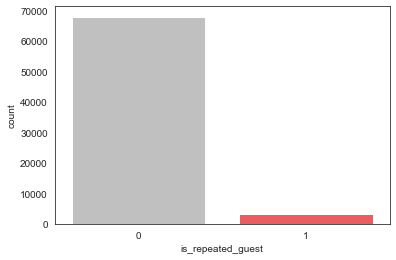

,is_repeated_guest,count
0,0,68028
1,1,3183


In [13]:
# repeated guests distribution

sns.barplot(df_clean.groupby('is_repeated_guest').nunique().index, df_clean.is_repeated_guest.value_counts(), palette=palette)
plt.ylabel('count')
plt.show()

df_clean['is_repeated_guest'].value_counts().rename_axis('is_repeated_guest').reset_index(name='count')

In [14]:
def percentage(part, whole):
    return 100 * part/whole

In [15]:
print(str(percentage(df_clean[df_clean['is_repeated_guest'] == 1].is_repeated_guest.count(), df_clean.shape[0]).round(2)) + '%' + 
      ' of the entire guest population are repeated guests.')

4.47% of the entire guest population are repeated guests.


#### Discrete Features

__Box plots__ and __Spearman's rank correlation coefficients__ will be used to examine the relationships between discrete variables and repeated guests (dichotomous variable).

In [16]:
# define discrete features (adr to be replaced with adr_binned)

disc = ['lead_time','stays_in_weekend_nights','stays_in_week_nights','adults','children','babies','previous_cancellations','previous_bookings_not_canceled',
        'booking_changes','days_in_waiting_list','adr','required_car_parking_spaces','total_of_special_requests','total_nights','total_kids']

In [17]:
df_clean[disc].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
lead_time,71211.0,80.892376,91.954987,0.00,9.0,46.00,126.0,709.0
stays_in_weekend_nights,71211.0,0.916333,0.981442,0.00,0.0,1.00,2.0,19.0
stays_in_week_nights,71211.0,2.435958,1.887202,0.00,1.0,2.00,3.0,50.0
adults,71211.0,1.827934,0.507806,0.00,2.0,2.00,2.0,4.0
children,71211.0,0.100645,0.387410,0.00,0.0,0.00,0.0,3.0
babies,71211.0,0.009872,0.111296,0.00,0.0,0.00,0.0,10.0
previous_cancellations,71211.0,0.016570,0.279588,0.00,0.0,0.00,0.0,13.0
previous_bookings_not_canceled,71211.0,0.213225,1.858793,0.00,0.0,0.00,0.0,72.0
booking_changes,71211.0,0.291697,0.723013,0.00,0.0,0.00,0.0,18.0
days_in_waiting_list,71211.0,1.672410,15.165815,0.00,0.0,0.00,0.0,379.0


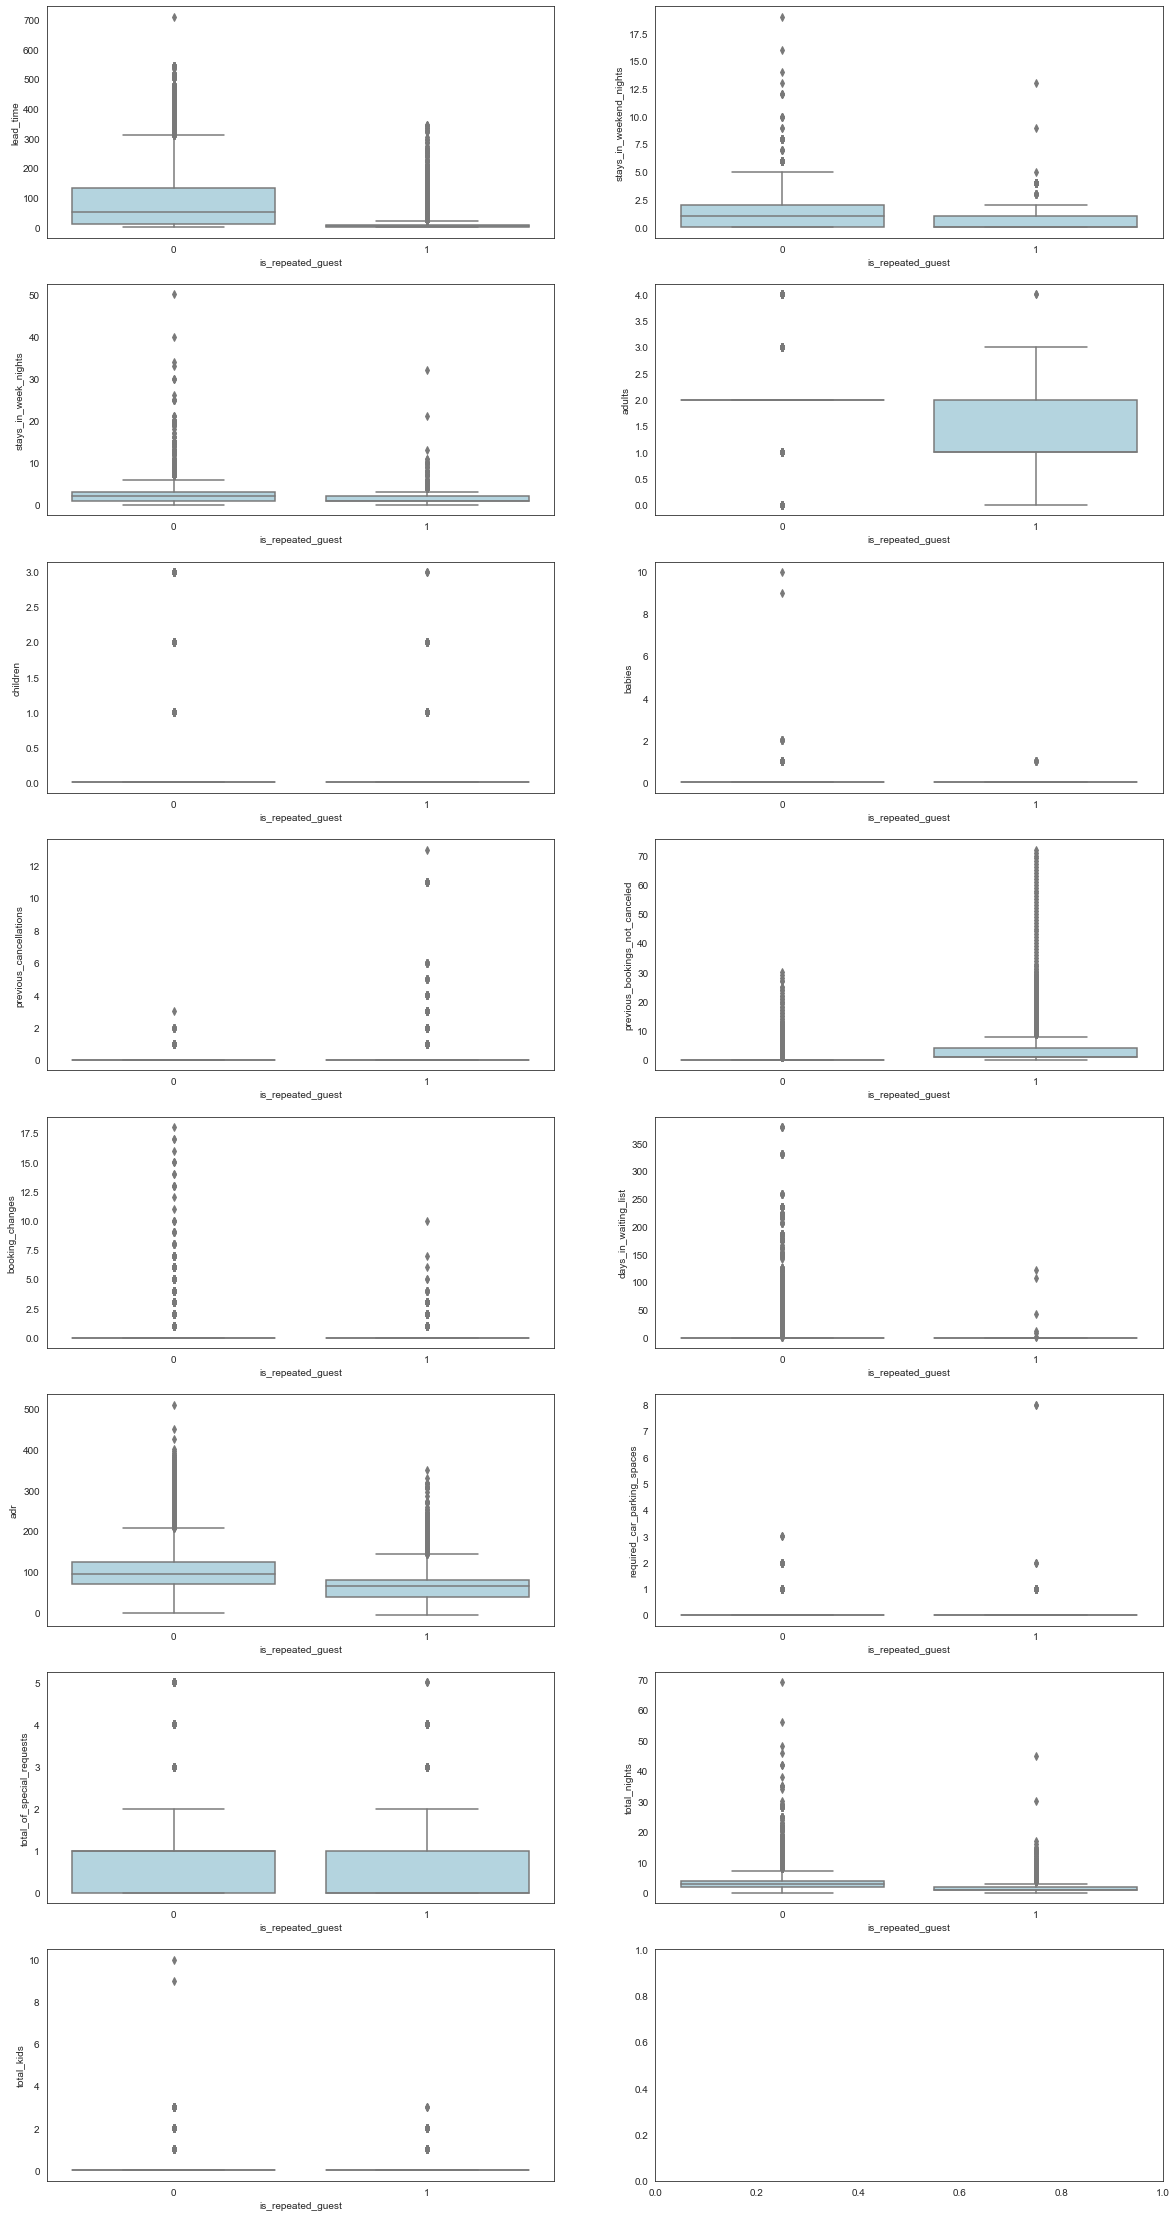

In [18]:
# loop that iterates discrete features in df_clean and creates a plot for each feature

f, ax = plt.subplots(8, 2, figsize=(20,40))

for column, ax in zip(disc, ax.flat):
    sns.boxplot(x='is_repeated_guest', y=column, data=df_clean, ax=ax, color='lightblue')

In [19]:
# replace adr with adr_binned

disc = ['adr_binned' if column == 'adr' else column for column in disc]

In [20]:
# Spearman's correlation coefficients will be used for correlation analysis between discrete and dichotomous (0 or 1) variables

disc_stat = pd.DataFrame({'feature':disc})

rs_list = []
pv_list = []

for column in disc:
    rs = stats.spearmanr(df_clean[column], df_clean['is_repeated_guest'])
    rs_list.append(rs[0])
    pv_list.append(rs[1])

disc_stat['spearman'] = rs_list
disc_stat['p-value'] = pv_list

disc_stat

,feature,spearman,p-value
0,lead_time,-0.228685,0.000000e+00
1,stays_in_weekend_nights,-0.115213,6.104904e-209
2,stays_in_week_nights,-0.148345,0.000000e+00
3,adults,-0.208376,0.000000e+00
4,children,-0.039510,5.231249e-26
5,babies,-0.012724,6.850808e-04
6,previous_cancellations,0.342576,0.000000e+00
7,previous_bookings_not_canceled,0.802057,0.000000e+00
8,booking_changes,0.004745,2.054582e-01
9,days_in_waiting_list,-0.026409,1.808911e-12


The **Spearman's correlation coefficient** (denoted by ρ or r<sub>s</sub>) measures the strength and direction of association between two ranked variables. Here, discrete values are treated as ranks since they are count-based. The correlation does not carry assumptions about the distribution of the data, and hence is a non-parametric statistic. The coefficients are constrained as -1 ≤ r<sub>s</sub> ≤ 1. The closer the r<sub>s</sub> is to ±1, the stronger the monotonic relationship. The Spearman's correlation coefficient of 0 implies no correlation.

**P-value** is the level of statistical significance between 0 and 1. The smaller the p-value, the stronger the evidence that the null hypothesis should be rejected. Typically, a p-value less than 0.05 (≤ 0.05) is statistically significant. A p-value higher than 0.05 (> 0.05) is not statistically significant and indicates strong evidence for the null hypothesis. The p-value is conditional upon the null hypothesis being true, but is unrelated to the truth of falsity of the alternative hypothesis. The null hypothesis can only be rejected or fail to be rejected; it cannot be accepted.

According to the Spearman's rank correlation coefficients, only one discrete features appear to have strong association with repeated guests (by interpretations defined below). P-values indicate that the null hypothesis (no correlation; ρ  = 0) is rejected for all the discrete features except *booking_changes*.

#### Categorical Features

__Bar graphs__, __chi-squared test__, and __Cramer's V__ will be used to examine the relationships between categorical variables and repeated guests (dichotomous variable).

In [21]:
# define categorical features

cat = ['hotel', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'agent', 'company', 
       'customer_type']

In [22]:
df_clean[cat].describe().transpose()

,count,unique,top,freq
hotel,71211,2,City Hotel,44385
meal,71211,5,BB,55048
country,71211,165,PRT,19155
market_segment,71211,7,Online TA,34231
distribution_channel,71211,4,TA/TO,54696
reserved_room_type,71211,8,A,49631
assigned_room_type,71211,10,A,39121
deposit_type,71211,3,No Deposit,70992
agent,71211,311,9,18252
company,71211,329,0,65755


In [23]:
def display_sxs(dfs:list):
    output = ""
    for df in dfs:
        output += df.style.set_table_attributes("style='display:inline'")._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

In [24]:
def confusion_matrix(column):
    return pd.crosstab(df_clean[column], df_clean['is_repeated_guest'])

In [25]:
print("Confusion Matrices: ")

display_sxs([confusion_matrix('hotel'), confusion_matrix('meal'), confusion_matrix('customer_type'), confusion_matrix('deposit_type')])
print('\n')
display_sxs([confusion_matrix('market_segment'), confusion_matrix('distribution_channel'), confusion_matrix('reserved_room_type'), 
             confusion_matrix('assigned_room_type')])
print('\n')
display_sxs([confusion_matrix('country').sort_values(1, ascending=False).head(20), confusion_matrix('agent').sort_values(1, ascending=False).head(20), 
             confusion_matrix('company').sort_values(1, ascending=False).head(20)])
print('\n')

Confusion Matrices: 


is_repeated_guest,0,1
hotel,,
City Hotel,42858,1527
Resort Hotel,25170,1656
is_repeated_guest,0,1
meal,,
BB,52134,2914
FB,241,9
HB,8364,159
SC,6426,81
Undefined,863,20


is_repeated_guest,0,1
market_segment,,
Aviation,130,53
Complementary,397,205
Corporate,2833,1371
Direct,9190,730
Groups,7081,44
Offline TA/TO,14678,268
Online TA,33719,512
is_repeated_guest,0,1
distribution_channel,,


is_repeated_guest,0,1
country,,
PRT,16499,2656
GBR,9310,105
ESP,5658,82
FRA,8201,69
ITA,2245,38
IRL,2372,29
DEU,5956,24
NLD,1658,20
USA,1535,18


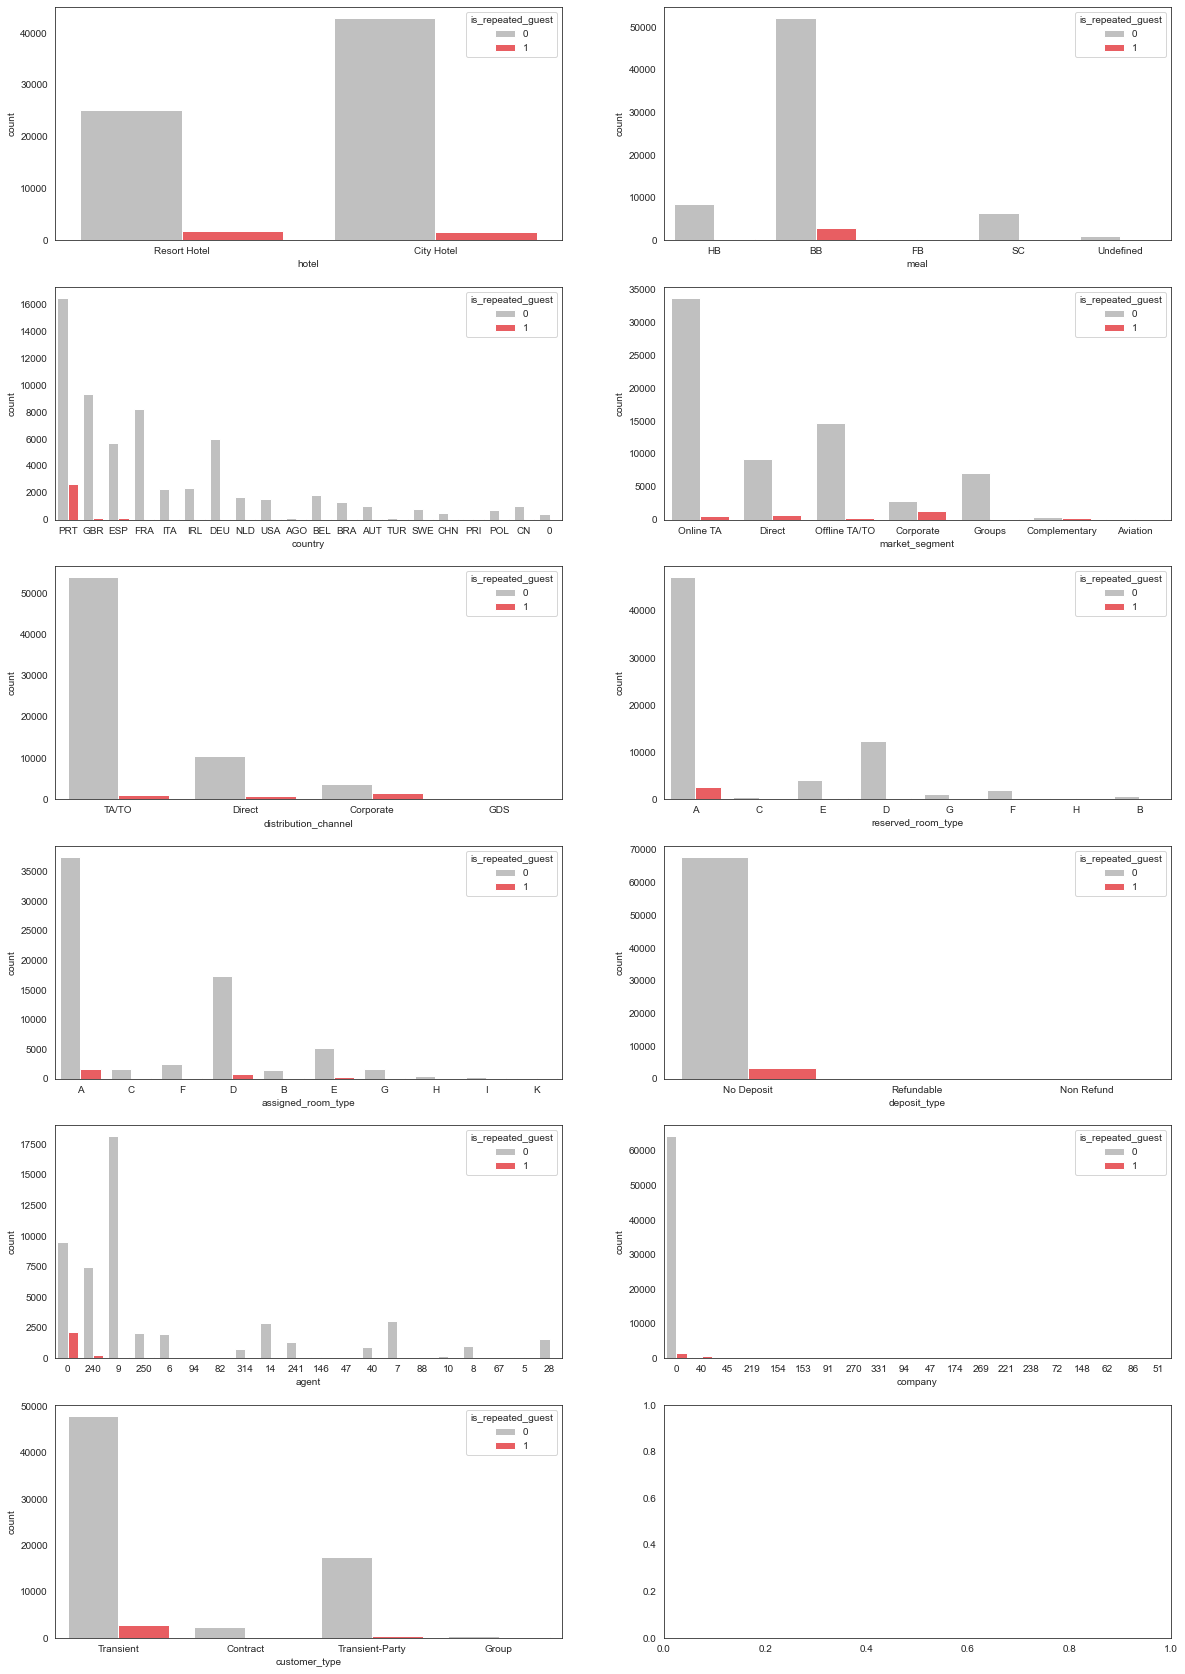

In [26]:
# loop that iterates categorical features in df_clean and creates a plot for each feature

f, ax = plt.subplots(6, 2, figsize=(20,30))

for column, ax in zip(cat, ax.flat):
    if len(df_clean[column].unique()) < 20:
        sns.countplot(x=column, hue='is_repeated_guest', data=df_clean, ax=ax, palette=palette)
    else:
        sns.countplot(x=column, hue='is_repeated_guest', data=df_clean, ax=ax, palette=palette, 
                      order=pd.value_counts(df_clean[column][df_clean.is_repeated_guest==1]).iloc[:20].index)

In [27]:
def cramers_corrected_stat(con_mat):
    chi2 = stats.chi2_contingency(con_mat)[0]
    n = con_mat.sum().sum()
    phi2 = chi2/n
    r,k = con_mat.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [28]:
# chi-squared test and cramer's v will be used for correlation analysis between categorical and dichotomous variables

cat_stat = pd.DataFrame({'feature':cat})

chisq_list = []
pv_list = []
crv_list = []

for column in cat:
    con_mat = pd.crosstab(df_clean[column], df_clean['is_repeated_guest'])
    chisq = stats.chi2_contingency(con_mat)[0]
    pv = stats.chi2_contingency(con_mat)[1]
    crv = cramers_corrected_stat(con_mat)
    chisq_list.append(chisq)
    pv_list.append(pv)
    crv_list.append(crv)

cat_stat['chi-squared'] = chisq_list
cat_stat['p-value'] = pv_list
cat_stat['cramer\'s v'] = crv_list

cat_stat

,feature,chi-squared,p-value,cramer's v
0,hotel,291.788524,2.027016e-65,0.063903
1,meal,391.840828,1.611150e-83,0.073800
2,country,5575.643952,0.000000e+00,0.275673
3,market_segment,10689.577403,0.000000e+00,0.387336
4,distribution_channel,8162.801725,0.000000e+00,0.338508
5,reserved_room_type,171.787328,1.054042e-33,0.048105
6,assigned_room_type,273.169532,1.263115e-53,0.060907
7,deposit_type,0.502276,7.779149e-01,0.000000
8,agent,9231.186831,0.000000e+00,0.353949
9,company,18309.273513,0.000000e+00,0.502504


**Chi-squared test** for independence determines whether there is a significant relationship between two categorical variables by examining their contingency table of observed values. Greater differences between the observed values and the expected values produce a larger chi-squared value. The larger the chi-squared value, the greater the probability that there really is a significant difference. If the observed values and the expected values are identical (no difference), the chi-squared value would be 0. Chi-squared test is sensitive to sample size and does not imply causality.

If the **p-value** obtained from chi-squared test for independence is significant (typically p ≤ 0.05), then the null hypothesis is rejected and there is a significant relationship (dependency) between the two variables. 

The **Cramer's V** determines the strength of a relationship between categorical variables. Assuming a low p-value from chi-squared test, the Cramer's V helps indicate the strength of the dependence. The coefficient ranges from 0 to 1; the closer to 1 the coefficient, the stronger the dependence. 

The test results show that there are several features with the Cramer's V values large enough to indicate strong correlations (see interpretations below). Only one of the test results is statistically insignificant with the p-value greater than 0.05, which is *deposit_type*.

#### Binary Features

__Bar graphs__, __chi-squared test__, and __phi coefficients__ will be used to examine the relationships between binary variables and repeated guests (dichotomous variable).

In [29]:
# define binary features

binary = ['room_type_change', 'kids']

In [30]:
df_clean[binary].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
room_type_change,71211.0,0.184396,0.387809,0.0,0.0,0.0,0.0,1.0
kids,71211.0,0.079300,0.270208,0.0,0.0,0.0,0.0,1.0


In [31]:
print("Confusion Matrices: ")

display_sxs([confusion_matrix('room_type_change'), confusion_matrix('kids')])

Confusion Matrices: 


is_repeated_guest,0,1
room_type_change,,
0,55869,2211
1,12159,972
is_repeated_guest,0,1
kids,,
0,62469,3095
1,5559,88


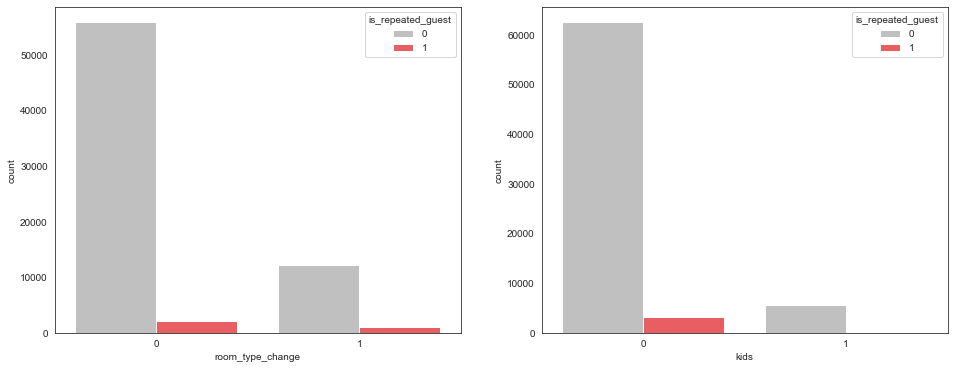

In [32]:
# loop that iterates binary features in df_clean and creates a plot for each

f, ax = plt.subplots(1, 2, figsize=(16,6))
    
for column, ax in zip(binary, ax.flat):
    sns.countplot(x=column, hue='is_repeated_guest', data=df_clean, ax=ax, palette=palette)

In [33]:
# chi-squared test and phi will be used for correlation analysis between binary and dichotomous variables

bin_stat = pd.DataFrame({'feature':binary})

chisq_list = []
pv_list = []
phi_list = []

for column in binary:
    y1 = df_clean['is_repeated_guest']
    y2 = df_clean[column]
    con_mat = pd.crosstab(df_clean[column], df_clean['is_repeated_guest'])
    chisq = stats.chi2_contingency(con_mat)[0]
    pv = stats.chi2_contingency(con_mat)[1]
    phi = matthews_corrcoef(y1, y2)
    chisq_list.append(chisq)
    pv_list.append(pv)
    phi_list.append(phi)

bin_stat['chi-squared'] = chisq_list
bin_stat['p-value'] = pv_list
bin_stat['phi'] = phi_list

bin_stat

,feature,chi-squared,p-value,phi
0,room_type_change,323.400071,2.632111e-72,0.067478
1,kids,121.017172,3.788385e-28,-0.041350


Like the Cramer's V, **phi** coefficient is a chi-squared based measure of association. It determines the strength of a relationship between two binary variables. Phi values range from -1 to 1. A phi value of 1 indicates a perfect positive relationship and a phi value of -1 indicates a perfect negative relationship. A phi value of 0 indicates no relationship between the variables.

Both the binary variables have significant p-values, but the phi coefficients indicate that the strength of their relationships to repeated guests are negligible.

#### Time Series Features

In [34]:
# define time series features

time = ['arrival_date_month']

In [35]:
monthly_resort = resort[resort.is_repeated_guest == 1].groupby(time)['is_canceled'].count().reset_index()
monthly_resort.columns = ['month','repeated']

monthly_not_resort = resort[resort.is_repeated_guest == 0].groupby(time)['is_canceled'].count().reset_index()
monthly_not_resort.columns = ['month','not_repeated']

monthly_resort['not_repeated'] = monthly_not_resort['not_repeated']
monthly_resort = sd.Sort_Dataframeby_Month(df=monthly_resort, monthcolumnname='month')
monthly_resort

,month,repeated,not_repeated
0,January,213,1653
1,February,228,2080
2,March,238,2333
3,April,171,2379
4,May,158,2377
5,June,120,1917
6,July,72,2007
7,August,71,2143
8,September,37,2065
9,October,80,2495


In [36]:
monthly_city = city[city.is_repeated_guest == 1].groupby(time)['is_canceled'].count().reset_index()
monthly_city.columns = ['month','repeated']

monthly_not_city = city[city.is_repeated_guest == 0].groupby(time)['is_canceled'].count().reset_index()
monthly_not_city.columns = ['month','not_repeated']

monthly_city['not_repeated'] = monthly_not_city['not_repeated']
monthly_city = sd.Sort_Dataframeby_Month(df=monthly_city, monthcolumnname='month')
monthly_city

,month,repeated,not_repeated
0,January,168,2081
1,February,133,2918
2,March,162,3887
3,April,84,3926
4,May,190,4378
5,June,141,4217
6,July,100,4213
7,August,60,4065
8,September,88,4195
9,October,153,4173


In [37]:
def two_scales(ax1, time, data1, data2, c1, c2):
    ax2 = ax1.twinx()
    ax1.plot(time, data1, color=c1, marker='o', label='not repeated')
    ax2.plot(time, data2, color=c2, marker='o', label='repeated')
    return ax1, ax2

def color_y_axis(ax, color):
    for t in ax.get_yticklabels():
        t.set_color(color)

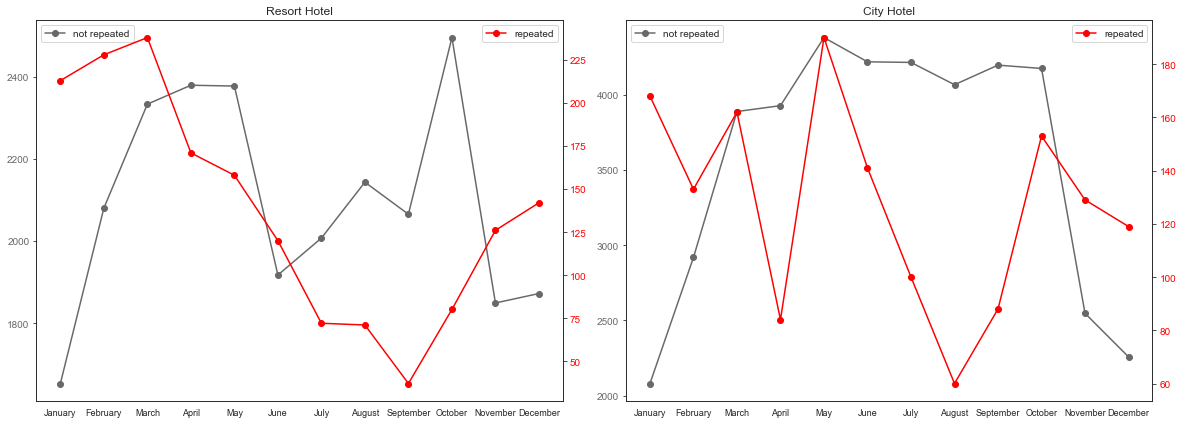

In [38]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,7))
ax1a, ax1b = two_scales(ax1, monthly_resort.month, monthly_resort.not_repeated, monthly_resort.repeated, 'dimgrey', 'r')
ax2a, ax2b = two_scales(ax2, monthly_city.month, monthly_city.not_repeated, monthly_city.repeated, 'dimgrey', 'r')
ax1.set_title('Resort Hotel')
ax2.set_title('City Hotel')

color_y_axis(ax1a, 'dimgrey')
color_y_axis(ax1b, 'r')
color_y_axis(ax2a, 'dimgrey')
color_y_axis(ax2b, 'r')

ax1a.legend(loc='upper left')
ax1b.legend(loc='upper right')
ax2a.legend(loc='upper left')
ax2b.legend(loc='upper right')

ax1.tick_params(axis='x', which='major', labelsize=9)
ax2.tick_params(axis='x', which='major', labelsize=9)

fig.subplots_adjust(wspace=0.12)

plt.show()

The repeated guests at the Resort Hotel decline from Spring to Autumn but are frequent during the winter. The number of non-repeated guests hikes during the spring and in October, but stays relatively low for the rest of the year. For the City Hotel, the number of repeated guests does not seem consistent with the seasons. The number of the new guests stays inflated throughout the year except for the coldest season of the year.

### Statistical Summary

Brief descriptions on how each feature is evaluated by their correlation coefficient and p-value. Functions that distingush relevant features based on their statistical test results will be defined and applied to all features. Statistical summary charts will be aligned horizontally so as to be accessible in a single view.

In [39]:
# function that boldizes features with strong correlations based on effect size

def correlated(df, threshold, column):
    is_max = pd.Series(data=False, index=df.index)
    is_max[column] = df.loc[column] > threshold
    return ['font-weight: bold' if is_max.any() else '' for v in is_max]

In [40]:
# functon that greys out features that are not significant based on p-values

def insignificant(df, threshold):
    is_min = pd.Series(data=False, index=df.index)
    is_min['p-value'] = df.loc['p-value'] > threshold
    return ['color: grey' if is_min.any() else '' for v in is_min]

In [41]:
alpha = 0.05

rs_thres = 0.40
cv_thres = 0.15
phi_thres = 0.15

disc_sum = disc_stat.style.apply(correlated, threshold=rs_thres, column=['spearman'], axis=1).apply(insignificant, threshold=alpha, axis=1).\
           set_table_attributes("style='display:inline'").set_caption('Discrete')
cat_sum = cat_stat.style.apply(correlated, threshold=cv_thres, column=['cramer\'s v'], axis=1).apply(insignificant, threshold=alpha, axis=1).\
          set_table_attributes("style='display:inline'").set_caption('Categorical')
bin_sum = bin_stat.style.apply(correlated, threshold=phi_thres, column=['phi'], axis=1).apply(insignificant, threshold=alpha, axis=1).\
          set_table_attributes("style='display:inline'").set_caption('Binary')

In [42]:
display_html(disc_sum._repr_html_()+'\xa0\xa0'+cat_sum._repr_html_()+'\xa0\xa0'+bin_sum._repr_html_(), raw=True)
print("Size of the sample: ", df_clean.shape[0])

,feature,spearman,p-value
0,lead_time,-0.228685,0.000000
1,stays_in_weekend_nights,-0.115213,0.000000
2,stays_in_week_nights,-0.148345,0.000000
3,adults,-0.208376,0.000000
4,children,-0.039510,0.000000
5,babies,-0.012724,0.000685
6,previous_cancellations,0.342576,0.000000
7,previous_bookings_not_canceled,0.802057,0.000000
8,booking_changes,0.004745,0.205458
9,days_in_waiting_list,-0.026409,0.000000


Size of the sample:  71211


Upon each feature, an appropriate correlation test for its data type and the p-value approach were conducted in order to determine the strength of the relationships (dependencies). Features with strong relationship to repeated guests (i.e. strong correlation coefficients) are boldized. Features that are greyed out have statistically insignificant p-values. 

The thresholds for the correlation tests are set to 0.40 for Spearman's and 0.15 for Cramer's V and phi for the following grounds:

    [Spearman's] Correlations were considered as follows: less than 0.2 negligible association, 0.2 to 0.29 weak association, 0.3 to 0.39 moderate association, 0.4 to 0.69 strong association, and greater than 0.7 very strong association (Dancey and Reidy, 2004).
    
    Common interpretation of phi and Cramer's V is proposed as follows: >0.25, very strong; >0.15, strong; >0.10, moderate; >0.05, weak; and >0, no or very weak (Akoglu, 2018).

According to the above summary charts, only one discrete feature appears to be strongly associated with repeated guests. They also show that five of the categorical features have strong correlations to repeated guests, but this is fairly apparent as their chi-squared values are already large enough to indicate significant differences. **The statistics translate to mean that the six boldized features are fair factors to consider optimizing for the purpose of attracting more repeated guests.**

In [43]:
relevant_features = []

for i, row in disc_stat.iterrows():
    if (row['spearman'] > rs_thres) & (row['p-value'] <= alpha):
        relevant_features.append(row['feature'])
        
for i, row in cat_stat.iterrows():
    if (row['cramer\'s v'] > cv_thres) & (row['p-value'] <= alpha):
        relevant_features.append(row['feature'])

for i, row in bin_stat.iterrows():
    if (row['phi'] > phi_thres) & (row['p-value'] <= alpha):
        relevant_features.append(row['feature'])

print("According to the statistical test results, the following factors of hotel bookings may be related to the next possible repeated bookings: ")
print(*relevant_features, sep=', ')

According to the statistical test results, the following factors of hotel bookings may be related to the next possible repeated bookings: 
previous_bookings_not_canceled, country, market_segment, distribution_channel, agent, company


> ### References
> <br>
>
> Dancey, Christine P., and John Reidy. "Statistics without maths for psychology. Harlow." (2004).
>
> Akoglu, Haldun. "User's guide to correlation coefficients." *Turkish journal of emergency medicine* 18.3 (2018): 91-93.